In [59]:
import pandas as pd
import os
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt

# Set the default DPI
plt.rcParams['figure.dpi'] = 100  

well_info = pd.read_csv('well-loc.tsv', sep='\t')

# Path to the sensor data directory
sensor_data_path = 'sensor-data'

# List all TSV files in the directory
sensor_data_files = [f for f in os.listdir(sensor_data_path) if f.endswith('.tsv')]

# Sort the sensor_data_files list
sensor_data_files.sort(key= lambda x: int(x.split('.')[0]))

# Load and concatenate all sensor data files into one DataFrame
sensor_data_list = [pd.read_csv(os.path.join(sensor_data_path, file), sep='\t',
                                na_values="-9999") for file in sensor_data_files]

# Remove the data point with NaN value
well_info = well_info.dropna()
for sensor_data in sensor_data_list:
    sensor_data.dropna(inplace=True)

# Reset the index of the well_loc DataFrame to Well, X, Y
well_info.rename(columns={'井': 'Well'}, inplace=True)

# Reset the index of the sensor data DataFrame to Depth, Porosity, Hydrate Saturation
for idx, _ in enumerate(sensor_data_list):
	sensor_data_list[idx].columns = ['Depth', 'Porosity', 'Hydrate Saturation']

print(well_info.head())  # Display the first few rows to verify it's loaded correctly
print(sensor_data_list[0].head())  # Display the first few rows to verify it's loaded correctly

  Well      X      Y
0  w01  34500  45000
1  w02  36000  45050
2  w03  37050  45020
3  w04  37880  46000
4  w05  35000  46030
         Depth  Porosity  Hydrate Saturation
112  1832.0004    0.5236              0.0237
113  1832.1528    0.5208              0.0175
114  1832.3052    0.5196              0.0000
115  1832.4576    0.5156              0.0000
116  1832.6100    0.4971              0.0000


In [60]:
# Calculate the percentage of the data points contains the negative value in sensor data
negative_data = []
for idx, sensor_data in enumerate(sensor_data_list):
    condition = (sensor_data['Porosity'] < 0) | (sensor_data['Hydrate Saturation'] < 0)
    negative_data.append(len(sensor_data[condition]) / len(sensor_data))

# Plot the number of negative data points
fig = go.Figure(data=[go.Bar(x=sensor_data_files, y=negative_data)])
fig.update_layout(title_text='Number of negative data points in each sensor data file')
fig.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the sensor data
scaler = MinMaxScaler()
for idx, sensor_data in enumerate(sensor_data_list):
    sensor_data[['Porosity', 'Hydrate Saturation']] = scaler.fit_transform(sensor_data[['Porosity', 'Hydrate Saturation']])

In [61]:
# Calculate the percentage of the data points contains the negative value in sensor data
zero_data = []
for idx, sensor_data in enumerate(sensor_data_list):
    condition = (sensor_data['Porosity'] == 0)
    zero_data.append(len(sensor_data[condition]) / len(sensor_data))

# Plot the number of negative data points
fig = go.Figure(data=[go.Bar(x=sensor_data_files, y=zero_data)])
fig.update_layout(title_text='Number of zero data points in each sensor data files\' Porosity')
fig.show()


In [63]:
# Calculate the percentage of the data points contains the negative value in sensor data
zero_data = []
for idx, sensor_data in enumerate(sensor_data_list):
    condition = (sensor_data['Hydrate Saturation'] == 0)
    zero_data.append(len(sensor_data[condition]) / len(sensor_data))

# Plot the number of negative data points
fig = go.Figure(data=[go.Bar(x=sensor_data_files, y=zero_data)])
fig.update_layout(title_text='Number of zero data points in each sensor data files\' Hydrate Saturation')
fig.show()

In [48]:
def estimate_resource(sensor_data: pd.Series) -> float:
	"""Estimate the resource at a given location based on sensor data"""
	# Get the Porosity and the Hydrate saturation
	porosity = sensor_data['Porosity']
	hydrate_saturation = sensor_data['Hydrate Saturation']

	valid_volume = 1 # Assume the valid volume is 1 cubic meter
	factor = 155 # Assume the factor is 155

	# Calculate the resource estimate
	return valid_volume * porosity * hydrate_saturation * factor

In [49]:
esti_data_list: list[pd.DataFrame] = []

# Calculate the resource estimate for each sensor data in each depth
for sensor_data in sensor_data_list:
    estimation = pd.DataFrame()
    estimation['Estimated Resources'] = sensor_data.apply(estimate_resource, axis=1)
    estimation['Depth'] = sensor_data['Depth']
    esti_data_list.append(estimation)

esti_data_list[0]

Estimated Resources      Depth
112             25.581030  1832.0004
113             18.487664  1832.1528
114              0.000000  1832.3052
115              0.000000  1832.4576
116              0.000000  1832.6100
...                   ...        ...
1716             0.000000  2076.4500
1717             0.000000  2076.6024
1718             0.000000  2076.7548
1719             0.000000  2076.9072
1720             0.000000  2077.0596

[1609 rows x 2 columns]

In [50]:
# Determine the global min and max values for 'Estimated Resources'
global_min = min(df['Estimated Resources'].min() for df in esti_data_list)
global_max = max(df['Estimated Resources'].max() for df in esti_data_list)

# Create a 3D scatter plot
fig = go.Figure()

for idx, df in enumerate(esti_data_list):
    well_name = well_info.iloc[idx]['Well']
    x_coord = well_info.iloc[idx]['X']
    y_coord = well_info.iloc[idx]['Y']

    fig.add_trace(go.Scatter3d(
        x=[x_coord] * len(df),  # Repeat the X coordinate for each depth
        y=[y_coord] * len(df),  # Repeat the Y coordinate for each depth
        z=df['Depth'],  # Invert the depth values
        mode='markers',
        marker=dict(
            size=3,
            color=df['Estimated Resources'],  # Color points by estimated resources
            colorscale='Viridis',  # Set the colorscale
            cmin=global_min,  # Set global minimum
            cmax=global_max,  # Set global maximum
            colorbar=dict(
                title='Estimated Resources',  # Title of the color bar
                titleside='right',
                titlefont=dict(size=12),
                thickness=20,
                x=0.85  # Adjust the position of the color bar (if necessary)
            ),
            opacity=0.8
        ),
        name=f'Well {well_name}'
    ))

# Update plot layout
fig.update_layout(
    title='3D Plot of Resource Distribution by Depth',
    height=600,
    width=1200,
    scene=dict(
        xaxis_title='X Coordinate',
        yaxis_title='Y Coordinate',
        zaxis=dict(
            title='Depth',
            autorange='reversed'  # Automatically reverse the z-axis
        )
    ),
)

# Show only one color bar
# We ensure only the color bar of the last trace is visible
for trace in fig.data[:-1]:
    trace.marker.showscale = False

fig.show()

In [51]:
from scipy.interpolate import interp1d


def align_index_step_size(df, new_depth_step=0.1):

    # Create the new depth grid starting from the base depth
    min_depth = np.around(min(df['Depth']), decimals=1)
    max_depth = np.around(max(df['Depth']), decimals=1)
    new_depths = np.around(np.arange(min_depth, max_depth, new_depth_step), decimals=1)

    # Interpolate other columns
    interpolated_data = {}
    for column in df.columns:
        if column != 'Depth':
            # Create interpolation function
            f = interp1d(df['Depth'], df[column], bounds_error=False, fill_value="extrapolate")
            # Interpolate data
            interpolated_data[column] = f(new_depths)

    # Create new DataFrame with interpolated data and new depth grid
    interpolated_df = pd.DataFrame(interpolated_data, index=new_depths)
    interpolated_df.reset_index(inplace=True)
    interpolated_df.rename(columns={'index': 'Depth'}, inplace=True)
    return interpolated_df

In [52]:
from plotly.subplots import make_subplots

# Determine the global minimum and maximum depths across all wells for uniform y-axis
min_depth = min(df['Depth'].min() for df in esti_data_list)
max_depth = max(df['Depth'].max() for df in esti_data_list)

# Create a uniform depth grid
uniform_depths = np.around(np.arange(min_depth, max_depth + 0.1, 0.1), decimals=1)  # Adjust step size if necessary

# Update each dataset to include the uniform depth grid
uniform_datasets = []
for df in esti_data_list:
    df = align_index_step_size(df)
    # Set Depth as index and reindex with the uniform depths, filling missing values with 0
    uniform_df = df.set_index('Depth').reindex(uniform_depths, fill_value=0).reset_index()
    uniform_datasets.append(uniform_df)

# Create subplots: one for each well
num_wells = len(uniform_datasets)
fig = make_subplots(rows=1, cols=num_wells, subplot_titles=[f"Well {well}" for well in well_info['Well']])

# Add a line plot for each well
for idx, df in enumerate(uniform_datasets):
    well_name = well_info.iloc[idx]['Well']
    fig.add_trace(
        go.Scatter(
            x=df['Estimated Resources'],
            y=df['Depth'],
            mode='lines+markers',
            name=f'Well {well_name}',
            marker=dict(size=2),
            line=dict(width=1)
        ),
        row=1, col=idx+1
    )

# Update y-axis to be reversed and uniform
# Only show y-axis on the first and last subplot
for i in range(1, num_wells + 1):
    if i == 1:  # First subplot
        fig.update_yaxes(title_text="Depth (m)", autorange="reversed", range=[min_depth, max_depth],
                         row=1, col=i)
    elif i == num_wells:  # Last subplot
        fig.update_yaxes(autorange="reversed", range=[min_depth, max_depth],
                         row=1, col=i, showticklabels=True,  side='right')
    else:
        fig.update_yaxes(autorange="reversed", range=[min_depth, max_depth],
                         row=1, col=i, showticklabels=False)


In [53]:

# Update y-axis to be reversed and uniform
fig.update_yaxes(autorange="reversed", range=[min_depth, max_depth])

# Update layout to better fit the subplots
fig.update_layout(
    height=600,
    width=1550,
    title_text="Resource Distribution in Depth for Each Sensor Tower",
    showlegend=False
)

fig.show()

In [54]:
import plotly.express as px
# Sum the resources for each well
resource_sums = [df['Estimated Resources'].sum() for df in esti_data_list]
well_info['Total Resources'] = resource_sums

# Plotting using Plotly
fig = px.scatter(well_info, x='X', y='Y', size='Total Resources', color='Total Resources',
                 hover_name='Well', size_max=40,
                 title='Resource Distribution Across Wells',
                 labels={'X': 'X Coordinate', 'Y': 'Y Coordinate', 'Total Resources': 'Estimated Resources'})

fig.update_layout(
    height=600,
    width=700,
)

fig.show()

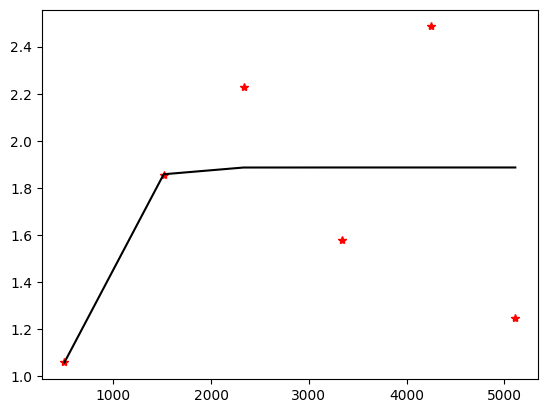

In [55]:
from pykrige.ok import OrdinaryKriging

# 假设 well_info 是一个包含井点信息的DataFrame，其中包含X坐标、Y坐标和资源总量
X = well_info['X']
Y = well_info['Y']
values = np.log(well_info['Total Resources'])

# 创建OrdinaryKriging对象，这里只是为了生成实验变异函数
ok = OrdinaryKriging(
    X,
    Y,
    values,
    variogram_model='gaussian',
    enable_plotting=True
)

In [56]:
# Define grid points for interpolation
grid_x = np.arange(min(X)-200, max(X)+200, 50.0)
grid_y = np.arange(min(Y)-200, max(Y)+200, 50.0)

# Perform the interpolation
z, ss = ok.execute('grid', grid_x, grid_y)


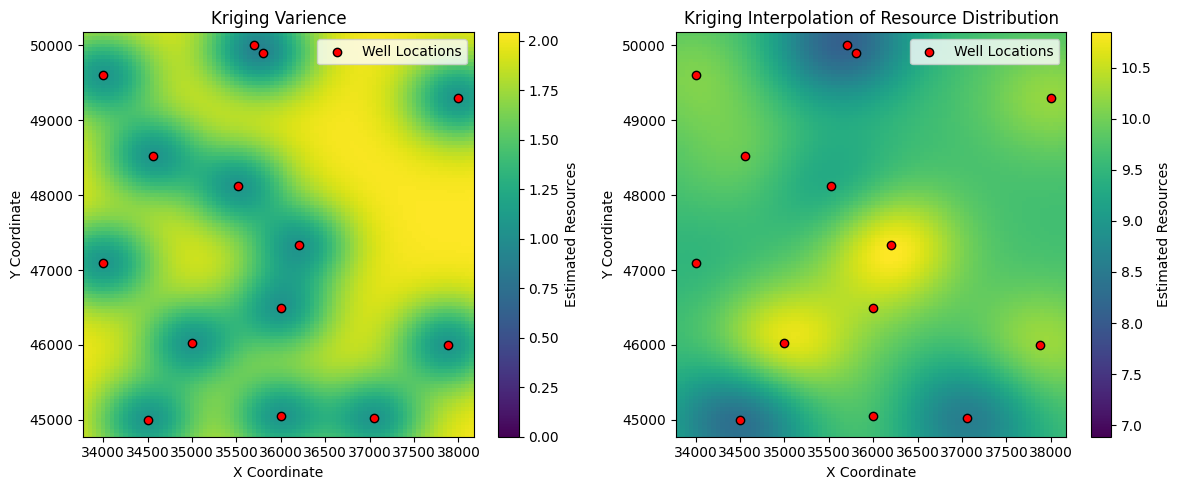

In [57]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first kriging result on the first subplot
c1 = axs[0].pcolormesh(grid_x, grid_y, ss, shading='auto')
fig.colorbar(c1, ax=axs[0], label='Estimated Resources')
axs[0].scatter(X, Y, color='red', edgecolor='black', label='Well Locations')
axs[0].set_xlabel('X Coordinate')
axs[0].set_ylabel('Y Coordinate')
axs[0].set_title('Kriging Varience')
axs[0].legend()

# Plot the second kriging result on the second subplot
c2 = axs[1].pcolormesh(grid_x, grid_y, z, shading='auto')
fig.colorbar(c2, ax=axs[1], label='Estimated Resources')
axs[1].scatter(X, Y, color='red', edgecolor='black', label='Well Locations')
axs[1].set_xlabel('X Coordinate')
axs[1].set_ylabel('Y Coordinate')
axs[1].set_title('Kriging Interpolation of Resource Distribution')
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()


In [58]:
from pykrige.ok3d import OrdinaryKriging3D
# Make kriging interpolation for Porosity  individually
data_frames = []
for i, df in enumerate(sensor_data_list):
    df['X'] = well_info.loc[i, 'X']
    df['Y'] = well_info.loc[i, 'Y']
    df['Well'] = well_info.loc[i, 'Well']
    data_frames.append(df)

combined_data = pd.concat(data_frames, ignore_index=True)

# Extract coordinates and values
cond = combined_data['Porosity'] > 0
X = combined_data[cond]['X'].values
Y = combined_data[cond]['Y'].values
Z = combined_data[cond]['Depth'].values
values = combined_data[cond]['Porosity'].values

# 创建OrdinaryKriging对象，这里只是为了生成实验变异函数
# Create the 3D Kriging model
kriging_model = OrdinaryKriging3D(
    X,
    Y,
    Z,
    values,
    variogram_model='linear',  # You might need to experiment with different models
    verbose=True,
    enable_plotting=True
)


Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...


KeyboardInterrupt: 

In [ ]:
# Define grid points for interpolation
grid_x = np.arange(min(X)-200, max(X)+200, 50.0)
grid_y = np.arange(min(Y)-200, max(Y)+200, 50.0)
grid_z = np.arange(min(Z)-1, max(Z)+1, 1.0)

# Perform the interpolation
t, ss = ok.execute('grid', grid_x, grid_y, grid_z)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Choose a depth level to visualize (example: the middle index of Z grid)
depth_idx = len(grid_z) // 2

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X, Y, Z, c=values, cmap='viridis')
cb = fig.colorbar(p, ax=ax)
cb.set_label('Estimated Resources')

# Overlay the interpolated values at a specific depth
slice_ = t[:, :, depth_idx]
x_slice, y_slice = np.meshgrid(grid_x, grid_y)
ax.contourf(x_slice, y_slice, slice_, zdir='z', offset=grid_z[depth_idx], cmap='viridis', alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth')

plt.title('Resource Distribution at Depth {:.2f}'.format(grid_z[depth_idx]))
plt.show()
